In [5]:
import sys
import os
import torch
import torchvision
import yaml

sys.path.append('vilbert-multi-task/')

from easydict import EasyDict as edict
from pytorch_transformers.tokenization_bert import BertTokenizer
from vilbert.datasets import ConceptCapLoaderTrain, ConceptCapLoaderVal
from vilbert.vilbert import VILBertForVLTasks, BertConfig, BertForMultiModalPreTraining
from vilbert.task_utils import LoadDatasetEval

import vilbert_utils
from vilbert_utils import FeatureExtractor

import numpy as np
import matplotlib.pyplot as plt
import PIL

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict
from PIL import Image
import cv2
import argparse
import glob
from types import SimpleNamespace
import pdb

import enoki as ek 
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')

from mitsuba.core import Thread, Vector3f
from mitsuba.core.xml import load_file
from mitsuba.python.util import traverse
from mitsuba.python.autodiff import render_torch, write_bitmap, render

import _pickle as cPickle

%matplotlib inline  

In [3]:
feature_extractor = FeatureExtractor()

args = SimpleNamespace(from_pretrained= "vilbert-multi-task/multi_task_model.bin",
                       bert_model="bert-base-uncased",
                       config_file="vilbert-multi-task/config/bert_base_6layer_6conect.json",
                       max_seq_length=101,
                       train_batch_size=1,
                       do_lower_case=True,
                       predict_feature=False,
                       seed=42,
                       num_workers=0,
                       baseline=False,
                       img_weight=1,
                       distributed=False,
                       objective=1,
                       visual_target=0,
                       dynamic_attention=False,
                       task_specific_tokens=True,
                       tasks='1',
                       save_name='',
                       in_memory=False,
                       batch_size=1,
                       local_rank=-1,
                       split='mteval',
                       clean_train_sets=True
                      )

config = BertConfig.from_json_file(args.config_file)
with open('./vilbert-multi-task/vilbert_tasks.yml', 'r') as f:
    task_cfg = edict(yaml.safe_load(f))

task_names = []
for i, task_id in enumerate(args.tasks.split('-')):
    task = 'TASK' + task_id
    name = task_cfg[task]['name']
    task_names.append(name)

timeStamp = args.from_pretrained.split('/')[-1] + '-' + args.save_name
config = BertConfig.from_json_file(args.config_file)
default_gpu=True

if args.predict_feature:
    config.v_target_size = 2048
    config.predict_feature = True
else:
    config.v_target_size = 1601
    config.predict_feature = False

if args.task_specific_tokens:
    config.task_specific_tokens = True    

if args.dynamic_attention:
    config.dynamic_attention = True

config.visualization = True
num_labels = 3129

if args.baseline:
    model = BaseBertForVLTasks.from_pretrained(
        args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
        )
else:
    model = VILBertForVLTasks.from_pretrained(
        args.from_pretrained, config=config, num_labels=num_labels, default_gpu=default_gpu
        )
    
model.eval()
cuda = torch.cuda.is_available()
if cuda: model = model.cuda(0)
tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)


# Load VQA label to answers:
label2ans_path = os.path.join('vilbert-multi-task', 'data', "datasets", "VQA" ,"cache", "trainval_label2ans.pkl")
vqa_label2ans = cPickle.load(open(label2ans_path, "rb"))

ans2label_path = os.path.join('vilbert-multi-task', 'data', "datasets", "VQA" ,"cache", "trainval_ans2label.pkl")
vqa_ans2label = cPickle.load(open(ans2label_path, "rb"))


12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.bias                  loaded from backbone.body.layer1.0.bn1.bias                  of shape (256,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.running_mean          loaded from backbone.body.layer1.0.bn1.running_mean          of shape (256,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.running_var           loaded from backbone.body.layer1.0.bn1.running_var           of shape (256,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn1.weight                loaded from backbone.body.layer1.0.bn1.weight                of shape (256,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.0.bn2.bias                  loaded from backbone.body.layer1.0.bn2.bias              

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn2.running_mean          loaded from backbone.body.layer1.2.bn2.running_mean          of shape (256,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn2.running_var           loaded from backbone.body.layer1.2.bn2.running_var           of shape (256,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn2.weight                loaded from backbone.body.layer1.2.bn2.weight                of shape (256,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn3.bias                  loaded from backbone.body.layer1.2.bn3.bias                  of shape (256,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer1.2.bn3.running_mean          loaded from backbone.body.layer1.2.bn3.running_mean      

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.bn3.running_var           loaded from backbone.body.layer2.1.bn3.running_var           of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.bn3.weight                loaded from backbone.body.layer2.1.bn3.weight                of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.conv1.weight              loaded from backbone.body.layer2.1.conv1.weight              of shape (512, 512, 1, 1)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.conv2.weight              loaded from backbone.body.layer2.1.conv2.weight              of shape (512, 16, 3, 3)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.1.conv3.weight              loaded from backbone.body.layer2.1.con

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn2.running_mean          loaded from backbone.body.layer2.4.bn2.running_mean          of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn2.running_var           loaded from backbone.body.layer2.4.bn2.running_var           of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn2.weight                loaded from backbone.body.layer2.4.bn2.weight                of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn3.bias                  loaded from backbone.body.layer2.4.bn3.bias                  of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.4.bn3.running_mean          loaded from backbone.body.layer2.4.bn3.running_mean      

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn1.bias                  loaded from backbone.body.layer2.7.bn1.bias                  of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn1.running_mean          loaded from backbone.body.layer2.7.bn1.running_mean          of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn1.running_var           loaded from backbone.body.layer2.7.bn1.running_var           of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn1.weight                loaded from backbone.body.layer2.7.bn1.weight                of shape (512,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer2.7.bn2.bias                  loaded from backbone.body.layer2.7.bn2.bias              

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn2.running_mean          loaded from backbone.body.layer3.1.bn2.running_mean          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn2.running_var           loaded from backbone.body.layer3.1.bn2.running_var           of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn2.weight                loaded from backbone.body.layer3.1.bn2.weight                of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn3.bias                  loaded from backbone.body.layer3.1.bn3.bias                  of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.1.bn3.running_mean          loaded from backbone.body.layer3.1.bn3.running_mean  

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn1.bias                 loaded from backbone.body.layer3.12.bn1.bias                 of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn1.running_mean         loaded from backbone.body.layer3.12.bn1.running_mean         of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn1.running_var          loaded from backbone.body.layer3.12.bn1.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn1.weight               loaded from backbone.body.layer3.12.bn1.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.12.bn2.bias                 loaded from backbone.body.layer3.12.bn2.bias         

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.bn3.running_var          loaded from backbone.body.layer3.14.bn3.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.bn3.weight               loaded from backbone.body.layer3.14.bn3.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv1.weight             loaded from backbone.body.layer3.14.conv1.weight             of shape (1024, 1024, 1, 1)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv2.weight             loaded from backbone.body.layer3.14.conv2.weight             of shape (1024, 32, 3, 3)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.14.conv3.weight             loaded from backbone.body.layer3.

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn2.running_mean         loaded from backbone.body.layer3.17.bn2.running_mean         of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn2.running_var          loaded from backbone.body.layer3.17.bn2.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn2.weight               loaded from backbone.body.layer3.17.bn2.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn3.bias                 loaded from backbone.body.layer3.17.bn3.bias                 of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.17.bn3.running_mean         loaded from backbone.body.layer3.17.bn3.running_mean 

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.bias                  loaded from backbone.body.layer3.2.bn1.bias                  of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.running_mean          loaded from backbone.body.layer3.2.bn1.running_mean          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.running_var           loaded from backbone.body.layer3.2.bn1.running_var           of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn1.weight                loaded from backbone.body.layer3.2.bn1.weight                of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.2.bn2.bias                  loaded from backbone.body.layer3.2.bn2.bias          

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.bn3.running_var          loaded from backbone.body.layer3.21.bn3.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.bn3.weight               loaded from backbone.body.layer3.21.bn3.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.conv1.weight             loaded from backbone.body.layer3.21.conv1.weight             of shape (1024, 1024, 1, 1)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.conv2.weight             loaded from backbone.body.layer3.21.conv2.weight             of shape (1024, 32, 3, 3)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.21.conv3.weight             loaded from backbone.body.layer3.

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn2.running_mean         loaded from backbone.body.layer3.24.bn2.running_mean         of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn2.running_var          loaded from backbone.body.layer3.24.bn2.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn2.weight               loaded from backbone.body.layer3.24.bn2.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn3.bias                 loaded from backbone.body.layer3.24.bn3.bias                 of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.24.bn3.running_mean         loaded from backbone.body.layer3.24.bn3.running_mean 

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn1.bias                 loaded from backbone.body.layer3.27.bn1.bias                 of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn1.running_mean         loaded from backbone.body.layer3.27.bn1.running_mean         of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn1.running_var          loaded from backbone.body.layer3.27.bn1.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn1.weight               loaded from backbone.body.layer3.27.bn1.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.27.bn2.bias                 loaded from backbone.body.layer3.27.bn2.bias         

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.bn3.running_var          loaded from backbone.body.layer3.29.bn3.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.bn3.weight               loaded from backbone.body.layer3.29.bn3.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.conv1.weight             loaded from backbone.body.layer3.29.conv1.weight             of shape (1024, 1024, 1, 1)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.conv2.weight             loaded from backbone.body.layer3.29.conv2.weight             of shape (1024, 32, 3, 3)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.29.conv3.weight             loaded from backbone.body.layer3.

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn2.running_mean         loaded from backbone.body.layer3.31.bn2.running_mean         of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn2.running_var          loaded from backbone.body.layer3.31.bn2.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn2.weight               loaded from backbone.body.layer3.31.bn2.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn3.bias                 loaded from backbone.body.layer3.31.bn3.bias                 of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.31.bn3.running_mean         loaded from backbone.body.layer3.31.bn3.running_mean 

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn1.bias                 loaded from backbone.body.layer3.34.bn1.bias                 of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn1.running_mean         loaded from backbone.body.layer3.34.bn1.running_mean         of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn1.running_var          loaded from backbone.body.layer3.34.bn1.running_var          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn1.weight               loaded from backbone.body.layer3.34.bn1.weight               of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.34.bn2.bias                 loaded from backbone.body.layer3.34.bn2.bias         

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.bn3.running_var           loaded from backbone.body.layer3.4.bn3.running_var           of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.bn3.weight                loaded from backbone.body.layer3.4.bn3.weight                of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.conv1.weight              loaded from backbone.body.layer3.4.conv1.weight              of shape (1024, 1024, 1, 1)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.conv2.weight              loaded from backbone.body.layer3.4.conv2.weight              of shape (1024, 32, 3, 3)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.4.conv3.weight              loaded from backbone.body.layer3.

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn2.running_mean          loaded from backbone.body.layer3.7.bn2.running_mean          of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn2.running_var           loaded from backbone.body.layer3.7.bn2.running_var           of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn2.weight                loaded from backbone.body.layer3.7.bn2.weight                of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn3.bias                  loaded from backbone.body.layer3.7.bn3.bias                  of shape (1024,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer3.7.bn3.running_mean          loaded from backbone.body.layer3.7.bn3.running_mean  

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn1.bias                  loaded from backbone.body.layer4.0.bn1.bias                  of shape (2048,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn1.running_mean          loaded from backbone.body.layer4.0.bn1.running_mean          of shape (2048,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn1.running_var           loaded from backbone.body.layer4.0.bn1.running_var           of shape (2048,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn1.weight                loaded from backbone.body.layer4.0.bn1.weight                of shape (2048,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.0.bn2.bias                  loaded from backbone.body.layer4.0.bn2.bias          

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn2.running_mean          loaded from backbone.body.layer4.2.bn2.running_mean          of shape (2048,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn2.running_var           loaded from backbone.body.layer4.2.bn2.running_var           of shape (2048,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn2.weight                loaded from backbone.body.layer4.2.bn2.weight                of shape (2048,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn3.bias                  loaded from backbone.body.layer4.2.bn3.bias                  of shape (2048,)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   backbone.body.layer4.2.bn3.running_mean          loaded from backbone.body.layer4.2.bn3.running_mean  

12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.1              loaded from rpn.anchor_generator.cell_anchors.1              of shape (3, 4)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.2              loaded from rpn.anchor_generator.cell_anchors.2              of shape (3, 4)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.3              loaded from rpn.anchor_generator.cell_anchors.3              of shape (3, 4)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.anchor_generator.cell_anchors.4              loaded from rpn.anchor_generator.cell_anchors.4              of shape (3, 4)
12/30/2020 00:21:53 - INFO - maskrcnn_benchmark.utils.model_serialization -   rpn.head.bbox_pred.bias                          loaded from rpn.head.bbox_pred.bias                      

2020-12-30 00:49:31 INFO main [xml.cpp:1221] Loading XML file "cbox/cbox.xml" ..

2020-12-30 00:49:31 INFO main [xml.cpp:1222] Using variant "gpu_autodiff_rgb"

2020-12-30 00:49:31 INFO main [xml.cpp:355] "cbox/cbox.xml": in-memory version upgrade (v0.4.0 -> v2.2.1) ..

2020-12-30 00:49:31 INFO main [Scene] Building scene in OptiX ..

12/30/2020 00:49:31 - WARNING - matplotlib.image -   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


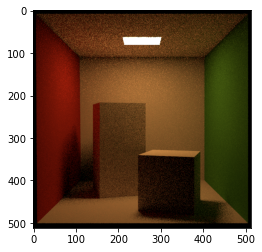

In [31]:
# Instantiate rendering things

Thread.thread().file_resolver().append('cbox')
scene = load_file('cbox/cbox.xml')

# Find differentiable scene parameters
params = traverse(scene)

# Discard all parameters except for one we want to differentiate
params.keep(['red.reflectance.value'])

# Render a reference image (no derivatives used yet)
#image_ref = render_torch(scene, spp=8, malloc_trim=True)

# ISSUE: I BELEIVE THE TORCH TENSORS ARE IN THE WRONG COLOR SPACE

image_ref = render(scene, spp=8)
image_ref = mitsuba.core.math.linear_to_srgb(image_ref).torch().reshape((512, 512, 3))
#crop_size = scene.sensors()[0].film().crop_size()
#write_bitmap('out_ref.png', image_ref, crop_size)

# Change the left wall into a bright white surface
#params['red.reflectance.value'] = [.9, .9, .9]
#params.update()

# Which parameters should be exposed to the PyTorch optimizer?
params_torch = params.torch()

# Construct a PyTorch Adam optimizer that will adjust 'params_torch'
opt = torch.optim.Adam(params_torch.values(), lr=.2)

plt.imshow(image_ref.detach().cpu())
plt.show()

In [4]:
# Define objective 

def objective(
    image,
    query="what color is the left wall", 
    target="green"
):
    # extract features
    features, infos = feature_extractor.extract_features(image)
    # make guess
    vil_prediction = vilbert_utils.custom_prediction(model, query, [1], features, infos, tokenizer)

    logits = torch.max(vil_prediction, 1)[1].cpu().data  # argmax
    answer = vqa_label2ans[logits[0].item()]

    print(f"Query: {query}, target: {target}, answer: {answer}")

    # Turn target word into one-hot tensor
    label = torch.tensor([vqa_ans2label[target]])
    score = torch.tensor([1]).double()
    target = torch.zeros(len(vqa_ans2label)).double()
    target.scatter_(0, label, score)

    # compute loss
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")
    loss = loss_fn(vil_prediction, target.unsqueeze(0).to(vil_prediction.device))
    loss = loss.mean()
    return loss

In [5]:
# Iterate 

iterations = 100
for it in range(iterations):
    opt.zero_grad()

    # Perform a differentiable rendering of the scene
    image = render_torch(scene, params=params, unbiased=True,
                         spp=1, malloc_trim=True, **params_torch)

    write_bitmap('out_%03i.png' % it, image, crop_size)

    # Objective: MSE between 'image' and 'image_ref'
    ob_val = objective(image)

    # Back-propagate errors to input parameters
    ob_val.backward()
    print(f"Loss: {ob_val.item()}")

    # Optimizer: take a gradient step
    opt.step()


torch.Size([512, 512, 3])


/home/alex/DifferentialRendering/vilbert-multi-task/vqa-maskrcnn-benchmark/maskrcnn_benchmark/structures/boxlist_ops.py:45: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  keep = ((ws >= min_size) & (hs >= min_size)).nonzero().squeeze(1)


Query: what color is the left wall, target: green, answer: black


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 5.93 GiB total capacity; 4.83 GiB already allocated; 21.62 MiB free; 4.93 GiB reserved in total by PyTorch)